# Video analysis and interpretation

## Imports, installs, downloading data

In [ ]:
import sys
import os
import datetime
import random
import re
import glob

# computer vision
from scipy import ndimage
from skimage import data, segmentation, filters
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
GCP_PROJECT_ID = 'hybrid-unity-339413'
GCS_BUCKET = 'msci-project'

if "google.colab" in sys.modules:
  from google.colab import auth
  auth.authenticate_user()
  os.environ["GOOGLE_CLOUD_PROJECT"] = GCP_PROJECT_ID

!mkdir /content/
!mkdir /content/videos/

!gsutil -m cp -r gs://msci-project/video_frames_collated/ /content/

mkdir: cannot create directory ‘/content/’: File exists
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0011.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0017.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0012.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0016.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0018.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0014.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0013.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0019.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0015.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0020.npy...
Copying gs://msci-project/video_frames_collated/dataset1/MS11_npy/images0021.npy...
Copying gs://msci-pr

## Functions to load videos to memory

In [ ]:
datasets = ['dataset1', 'dataset2']
labels = ['MS11', 'MX2', 'SN2']

# get videos and brightfield images from one class
# max videos/images ~100
def get_trial_videos(trial_label, num_videos):

  # valid label check
  if trial_label not in labels:
    print('Invalid label')

  trial_videos = []
  trial_brightfields = []

  # get videos from local (colab) storage
  for i in range(num_videos):
    video = glob.glob(f'/content/video_frames_collated/dataset1/{trial_label}_npy/video{i+11}.npy')[0] # videos start at 11
    video = np.load(video)
    video /= np.max(video)
    trial_videos.append(video)


    if i >= 89:
      image = glob.glob(f'/content/video_frames_collated/dataset1/{trial_label}_npy/images0{i+11}.npy')[0]
    else:
      image = glob.glob(f'/content/video_frames_collated/dataset1/{trial_label}_npy/images00{i+11}.npy')[0]
    trial_brightfields.append(np.load(image))
  
  return trial_videos, trial_brightfields

In [ ]:
trial_label = 'MS11'
num_videos = 10

# test function and validate
videos, brightfields = get_trial_videos(trial_label, num_videos=num_videos)

print(f'num videos expected: {num_videos}, got: {len(videos)}')
print(f'num brightfields expected: {num_videos}, got: {len(brightfields)}')

num videos expected: 10, got: 10
num brightfields expected: 10, got: 10


In [ ]:
# get random video and index and random frame from that video and its index
def get_single_video(n_frames=200):
  random_vid_n = np.random.choice(len(videos))
  random_vid = videos[random_vid_n]

  random_frame_n = np.random.choice(n_frames)
  random_frame = videos[random_vid_n][random_frame_n]
  return random_vid_n, random_vid, random_frame_n, random_frame

## Samples of frames and brightfield images



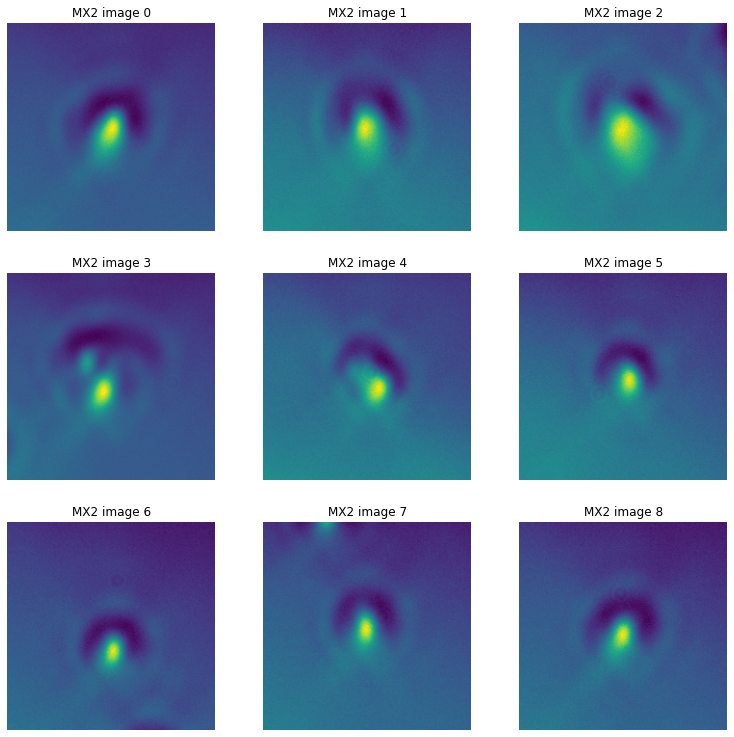

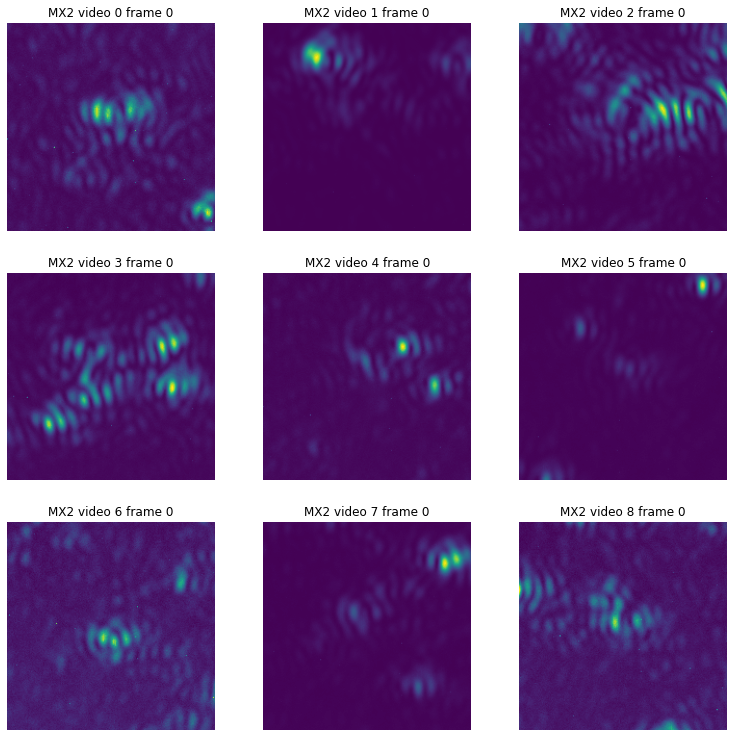

In [ ]:
def plot_videos_and_brightfield_examples(trial_label):

  videos, brightfields = get_trial_videos(trial_label, num_videos=9)
  fig, ax = plt.subplots(3,3, figsize=(13,13))
  for i in range(3):
    for j in range(3):
      ax[i,j].imshow(brightfields[3*i + j])
      ax[i,j].axis('off')
      ax[i,j].set(title=f'{trial_label} image {3*i + j}')
  
  fig, ax = plt.subplots(3,3, figsize=(13,13))

  sample_frame_num = 0

  for i in range(3):
    for j in range(3):
      ax[i,j].imshow(videos[3*i + j][sample_frame_num,:,:])
      ax[i,j].axis('off')
      ax[i,j].set(title=f'{trial_label} video {3*i + j} frame {sample_frame_num}')


plot_videos_and_brightfield_examples(labels[1])

# Analysis functions

## Traditional CV

In [ ]:
# useful plotting function to save duplicate code
def plot_with_brightfield(frame, result, title):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,13))
    
    fig.suptitle(f'{trial_label} Video {random_vid_n}')
    
    ax1.imshow(brightfields[random_vid_n])
    ax2.imshow(frame)
    ax3.imshow(result)
    
    ax1.set(title = 'Brightfield')
    ax2.set(title = 'Sample frame')
    ax3.set(title = title)
    
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    
    plt.tight_layout()
      
# perform 'bitwise_and' operator on each frame in sequence with frame ahead of it for whole video      
def bitwise_and(vid):
    result = cv2.bitwise_and(vid[0], vid[1])
    
    # renormalize brightness
    for frame in vid[2:]:
        result = cv2.bitwise_and(result, frame)
    
    return result, 'Bitwise_and over all frames'

# perform edge detection algorithm on single frame
def edge_detection(frame):
    sx = ndimage.sobel(frame, axis=0, mode='constant')
    sy = ndimage.sobel(frame, axis=1, mode='constant')
    sob = np.hypot(sx, sy)
    
    return sob, 'Edge detection'

# find regions of image
# small_region = False will select only largest
def region_detection(frame, small_region):
    mask = frame > frame.mean()
    label_im, nb_labels = ndimage.label(mask)
    
    sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
    #mean_vals = ndimage.sum(frame, label_im, range(1, nb_labels + 1))
    
    if not small_region:
        mask_size = sizes < 1000
        remove_pixel = mask_size[label_im]
        label_im[remove_pixel] = 0
        labels = np.unique(label_im)
        label_im = np.searchsorted(labels, label_im)        
        
    return label_im, f'Region detection, regions: {nb_labels}'
    
def bounding_box(frame):
    mask = frame > frame.mean()

    label_im, nb_labels = ndimage.label(mask)
    
    # Find the largest connected component
    sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
    mask_size = sizes < 1000
    remove_pixel = mask_size[label_im]
    label_im[remove_pixel] = 0
    labels = np.unique(label_im)
    label_im = np.searchsorted(labels, label_im)
    
    # Now that we have only one connected component, extract it's bounding box
    slice_x, slice_y = ndimage.find_objects(label_im==1)[0]
    roi = frame[slice_x, slice_y]
    
    return roi, 'bounding box around largest object'

# plot all above functions
def plot_all(random_vid_n, random_vid, random_frame_n, random_frame):

    result, title = bitwise_and(random_vid)
    plot_with_brightfield(random_frame, result, title)
    
    result, title = edge_detection(random_frame)
    plot_with_brightfield(random_frame, result, title)
    
    result, title = region_detection(random_frame, small_region=True)
    plot_with_brightfield(random_frame, result, title)
    
    result, title = region_detection(random_frame, small_region=False)
    plot_with_brightfield(random_frame, result, title)
    
    result, title = bounding_box(random_frame)
    plot_with_brightfield(random_frame, result, title)

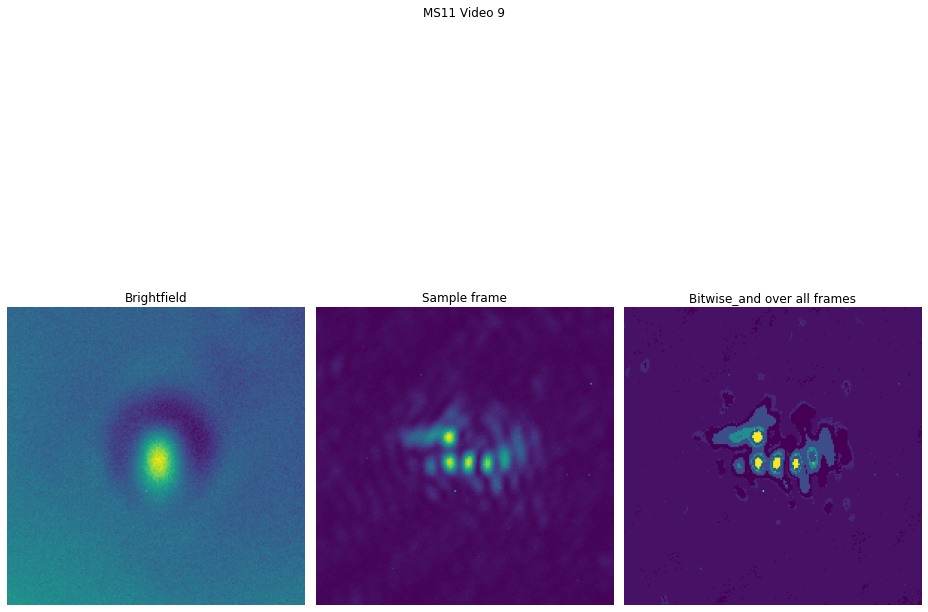

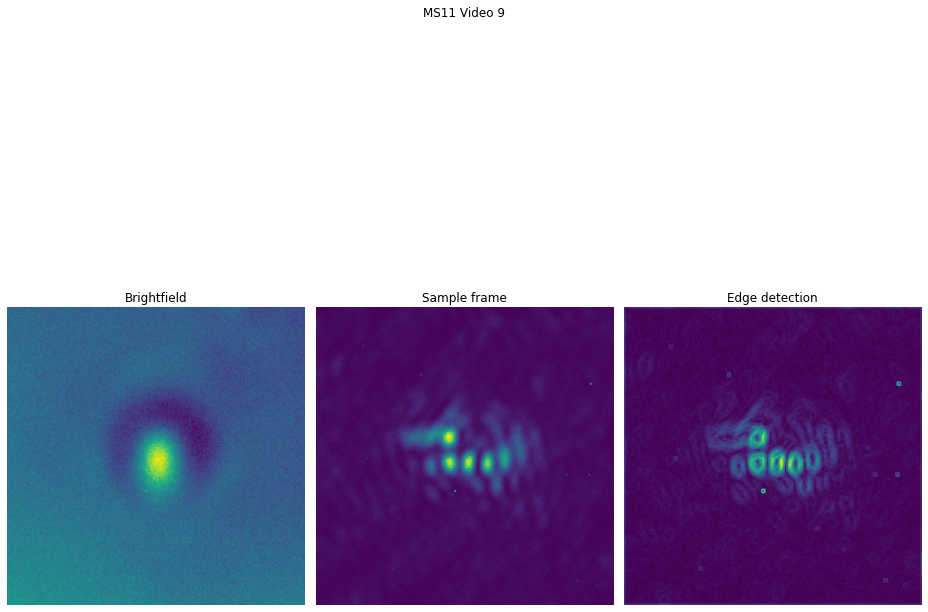

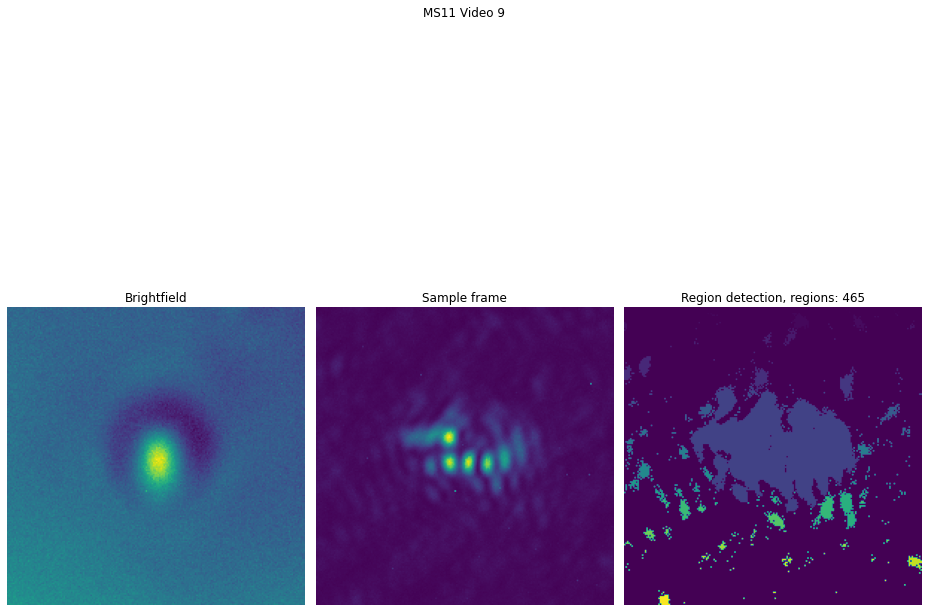

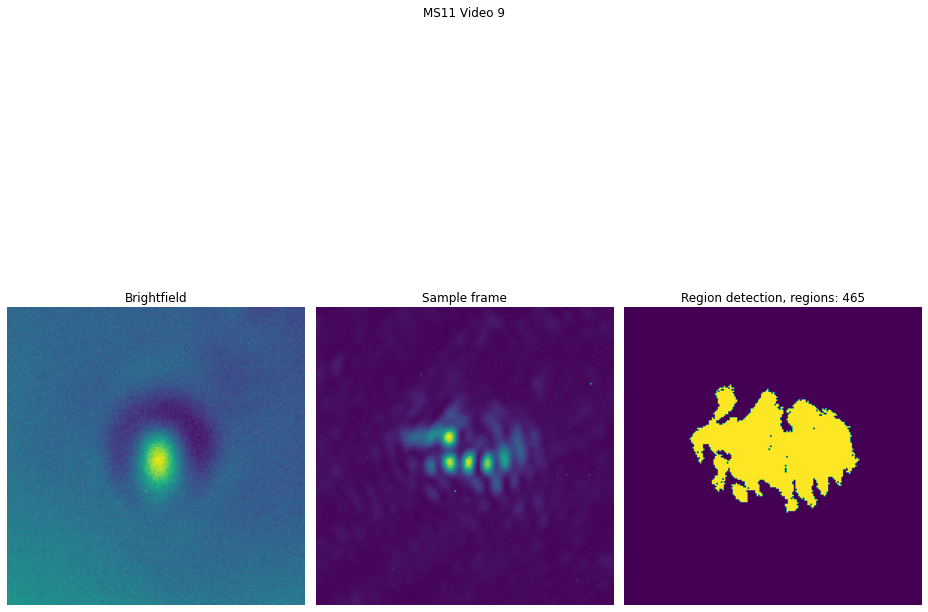

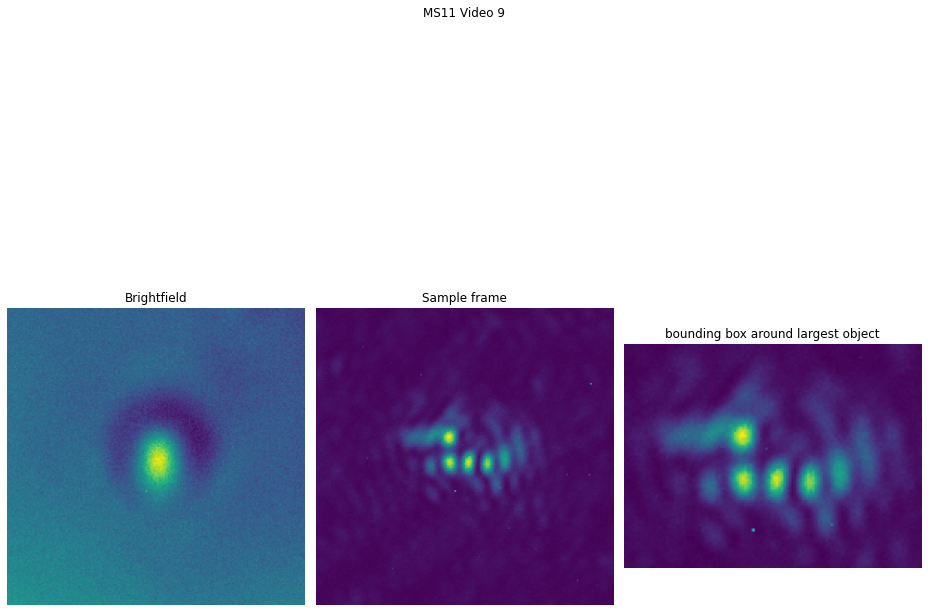

In [ ]:
# select a random frame
random_vid_n, random_vid, random_frame_n, random_frame = get_single_video()

plot_all(random_vid_n, random_vid, random_frame_n, random_frame)

## Feature 1: Standard deviation over frames (all pixels)
- How much video changes frame to frame
- Measure of fluctuation rate?

In [ ]:
def plot_feature_hist(value_MS11, value_MX2, value_SN2):
  # histogram
  max_sd_val = np.max([np.max(value_MS11[:,1]), np.max(value_MX2[:,1]), np.max(value_SN2[:,1])])

  bins = np.linspace(0, max_sd_val, 20)
  plt.hist([value_MS11[:,1], value_MX2[:,1], value_SN2[:,1]], bins, alpha=0.5, label=['MS11','MX2','SN2'])
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
def std_all_pixels():

  regex = re.compile(r'\d+') # for finding digits in filename

  sd_over_frames_MS11 = []
  sd_over_frames_MX2 = []
  sd_over_frames_SN2 = []

  for dataset in datasets:
    for bacterium in labels:
      videos = glob.glob(f'/content/video_frames_collated/{dataset}/{bacterium}_npy/video*.npy')
      for video in videos:
        for i in 
        vid_num = int(regex.findall(video[-7:-4])[0]) # find labelled number from video filename

        loaded_vid = np.load(video)
        loaded_vid /= np.max(loaded_vid) # is this normalisation correct?

        mean_std = np.mean(np.std(loaded_vid))

        if bacterium == 'MS11':
          sd_over_frames_MS11.append([vid_num,mean_std])
        elif bacterium =='MX2':
          sd_over_frames_MX2.append([vid_num,mean_std])
        elif bacterium == 'SN2':
          sd_over_frames_SN2.append([vid_num,mean_std])

  # feature no. 1
  sd_over_frames_MS11 = np.array(sd_over_frames_MS11)
  sd_over_frames_MX2 = np.array(sd_over_frames_MX2)
  sd_over_frames_SN2 = np.array(sd_over_frames_SN2)

  return sd_over_frames_MS11, sd_over_frames_MX2, sd_over_frames_SN2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


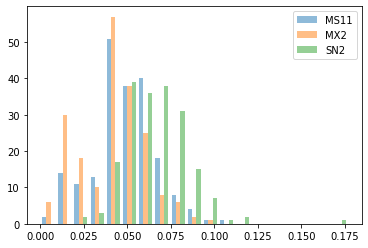

In [ ]:
# find all sd. over all frames over all pixels
# est. 2min runtime
sd_over_frames_MS11, sd_over_frames_MX2, sd_over_frames_SN2 = std_all_pixels()

# plot histogram
plot_feature_hist(sd_over_frames_MS11, sd_over_frames_MX2, sd_over_frames_SN2)

In [ ]:
def find_outliers(value):
  SN2_outliers_index = np.where(sd_over_frames_SN2[:,1] > value)[0]
  SN2_outlier_vid_num = sd_over_frames_SN2[SN2_outliers_index,0]

  MS11_outliers_index = np.where(sd_over_frames_MS11[:,1] > value)[0]
  MS11_outlier_vid_num = sd_over_frames_MS11[MS11_outliers_index,0]

  MX2_outliers_index = np.where(sd_over_frames_MX2[:,1] > value)[0]
  MX2_outlier_vid_num = sd_over_frames_MX2[MX2_outliers_index,0]

  print(f'Outliers are standard deviations > {value}')
  print(f'Outlier values: SN2: {sd_over_frames_SN2[SN2_outliers_index,1]}, MS11: {sd_over_frames_MS11[MS11_outliers_index,1]}, MX2: {sd_over_frames_MX2[MX2_outliers_index,1]}')
  print(f'Outlier video index: SN2 {SN2_outliers_index}, MS11: {MS11_outliers_index}, MX2: {MX2_outliers_index}')
  print(f'Outlier video number (storage): SN2: {SN2_outlier_vid_num}, MS11: {MS11_outlier_vid_num}, MX2: {MX2_outlier_vid_num}') 

find_outliers(0.15)

Outliers are standard deviations > 0.15
Outlier values: SN2: [0.17697431], MS11: [], MX2: []
Outlier video index: SN2 [71], MS11: [], MX2: []
Outlier video number (storage): SN2: [16.], MS11: [], MX2: []


### Example Outlier analysis
SN2 vid 16 is an outlier, plotted below

In [ ]:
def outlier_analyis_sd_val(bacterium, index, vid_num):
  print(f'mean standard deviation for SN2: {np.mean(sd_over_frames_SN2[:,1])}, and vid {SN2_outlier_vid_num}: {sd_over_frames_SN2[SN2_outliers_index,1]}')

  fig, ax = plt.subplots(3,3, figsize=(13,13))

  for i in range(3):
    for j in range(3):
      SN2_vid_i = 3*i + j
      SN2_vid_n = SN2_vid_i + SN2_outlier_vid_num

      SN2_vid = np.load(f'/content/video_frames_collated/dataset1/SN2_npy/video{SN2_vid_n}.npy')
      ax[i,j].imshow(SN2_vid[0,:,:])
      ax[i,j].set(title=f'SN2 vid {SN2_vid_n}, std={np.round(sd_over_frames_SN2[SN2_outliers_index + SN2_vid_i,1], 3)}')
      ax[i,j].axis('off')

outlier_analyis_sd_val()

TypeError: ignored

## Feature 2: SD per pixel over all frames
- How much each pixel changes over course of video
- Measure of spread/size of fluctuations?

In [ ]:
def plot_example_sd_per_pixel():
  pixel_sd = np.zeros(shape=(np.shape(random_vid)[1], np.shape(random_vid)[2]))

  vid = videos[4]

  for i in range(200):
    for j in range(200):
      pixel_sd[i,j] = np.std(vid[:,i,j])

  # calculate standard deviation of each pixel over all frames of video
  fig, ax = plt.subplots(1,2, figsize=(13,13))
  ax[0].imshow(pixel_sd)
  ax[0].set(title=f'Standard deviation per pixel over all frames of {trial_label} video {random_vid_n}')

  ax[1].imshow(vid[0,:,:])
  ax[1].set(title=f'First frame of {trial_label} video {random_vid_n}')

  # explore a few different thresholds
  fig, ax = plt.subplots(3,3, figsize=(13,13))

  copy = np.copy(pixel_sd)

  fig.suptitle('Locating threshold values')

  # quantiles
  # avg position 
  threshold_vals = np.linspace(0, np.max(copy), 9)

  for i in range(3):
    for j in range(3):
      k = np.round(threshold_vals[3*i + j],2)
      copy[copy < k] = 0
      ax[i,j].imshow(copy)
      ax[i,j].set(title=k)
      ax[i,j].axis('off')

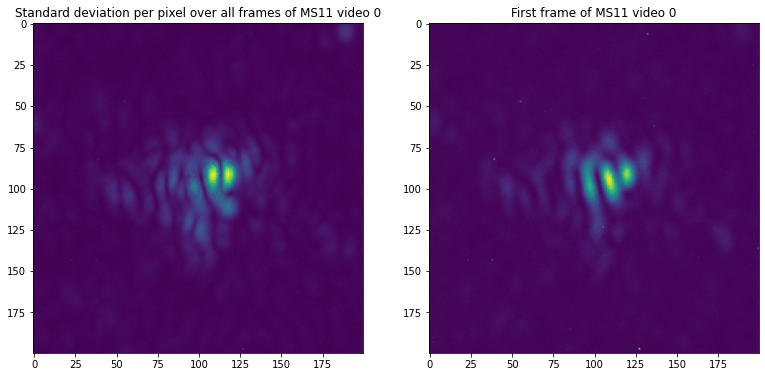

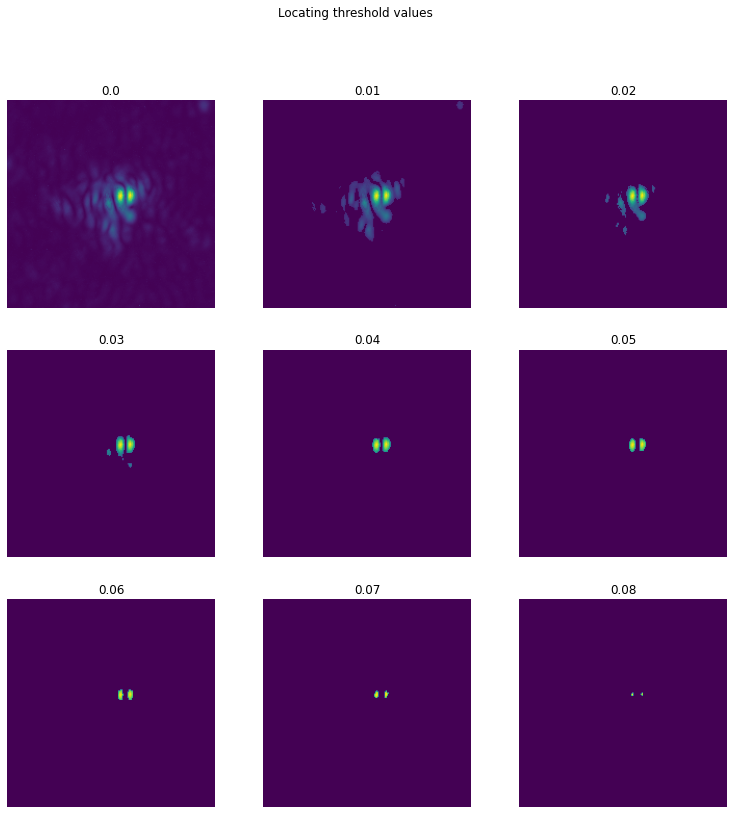

In [ ]:
plot_example_sd_per_pixel()

In [ ]:
def std_per_pixels():

  regex = re.compile(r'\d+') # for finding digits in filename

  sd_per_pixel_MS11 = []
  sd_per_pixel_MX2 = []
  sd_per_pixel_SN2 = []

  for dataset in datasets:
    for bacterium in labels:
      videos = glob.glob(f'/content/video_frames_collated/{dataset}/{bacterium}_npy/video*.npy')
      for video in videos:
        vid_num = int(regex.findall(video[-7:-4])[0]) # find labelled number from video filename

        loaded_vid = np.load(video)
        loaded_vid /= np.max(loaded_vid) # is this normalisation correct?

        pixel_sd = np.zeros(shape=(np.shape(random_vid)[1], np.shape(random_vid)[2]))

        for i in range(200):
          for j in range(200):
            pixel_sd[i,j] = np.std(loaded_vid[:,i,j])
        
        std_of_video = np.std(pixel_sd)
        if bacterium == 'MS11':
          sd_per_pixel_MS11.append([vid_num,std_of_video])
        elif bacterium == 'MX2':
          sd_per_pixel_MX2.append([vid_num,std_of_video])
        elif bacterium == 'SN2':
          sd_per_pixel_SN2.append([vid_num,std_of_video])
        
  sd_per_pixel_MS11 = np.array(sd_per_pixel_MS11)
  sd_per_pixel_MX2 = np.array(sd_per_pixel_MX2)
  sd_per_pixel_SN2 = np.array(sd_per_pixel_SN2)

  return sd_per_pixel_MS11, sd_per_pixel_MX2, sd_per_pixel_SN2

In [ ]:
# find all sd. over all frames over all pixels
# est 14 min runtime
sd_per_pixel_MS11, sd_per_pixel_MX2, sd_per_pixel_SN2 = std_per_pixels()

plot_feature_hist(sd_per_pixel_MS11, sd_per_pixel_MX2, sd_per_pixel_SN2)

## Feature 3: Bacterium size

In [ ]:
def region_detection_skimage(frame):

  # otsu thresholding
  mask = frame > filters.threshold_otsu(frame)
  clean_border = segmentation.clear_border(mask)

  return clean_border

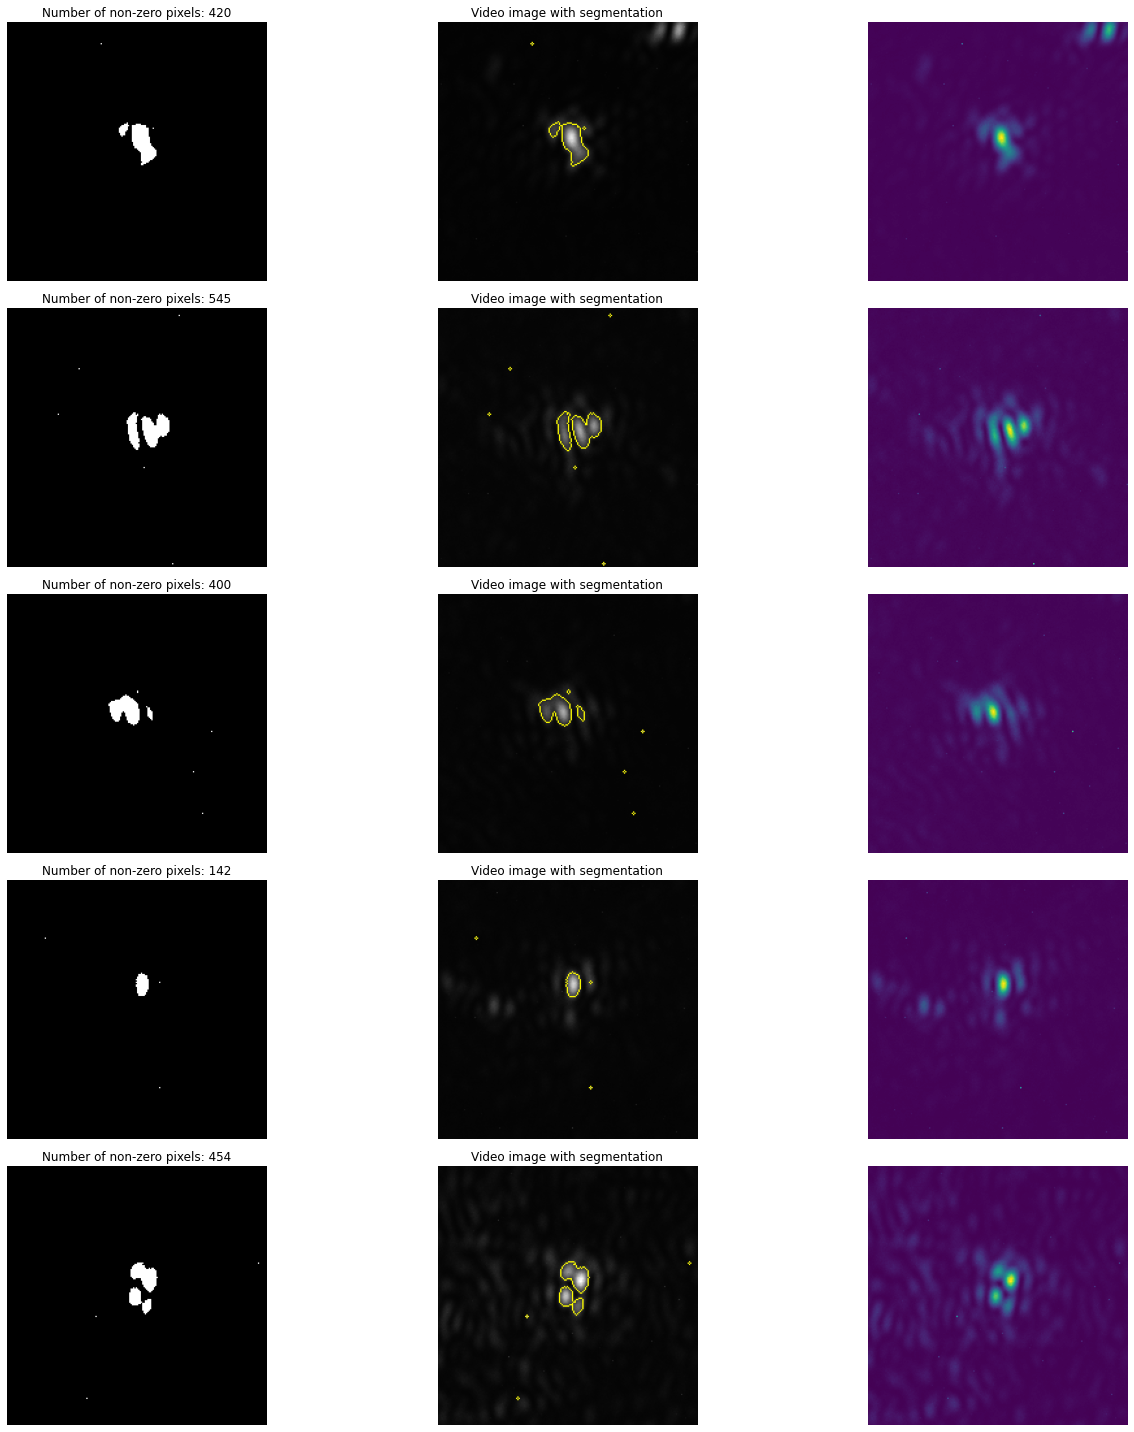

In [ ]:
def plot_borders_and_seg_skimage(frame):

  fig, ax = plt.subplots(5,3, figsize=(20,20))
  for i in range(5):
    clean_border = region_detection_skimage(frame[i])
    frame_edges = segmentation.mark_boundaries(frame[i], clean_border)

    plt.imshow(clean_border)

    ax[i,0].imshow(clean_border, cmap='gray')
    ax[i,0].axis('off')
    ax[i,0].set(title=f'Number of non-zero pixels: {np.count_nonzero(clean_border)}')

    ax[i,1].imshow(frame_edges)
    ax[i,1].axis('off')
    ax[i,1].set(title=f'Video image with segmentation')

    ax[i,2].imshow(frame[i])
    ax[i,2].axis('off')

  plt.tight_layout()
  plt.show()

# 5 random videos, first frame
frames = [videos[2][0], videos[4][0], videos[6][0], videos[8][0], videos[3][0]]

plot_borders_and_seg_skimage(frames)

In [ ]:
def bacteria_size():

  labels = ['MS11', 'MX2', 'SN2']
  regex = re.compile(r'\d+') # for finding digits in filename

  size_MS11 = []
  size_MX2 = []
  size_SN2 = []

  for dataset in datasets:
    for bacterium in labels:
      videos = glob.glob(f'/content/video_frames_collated/{dataset}/{bacterium}_npy/video*.npy')
      for video in videos:
        vid_num = int(regex.findall(video[-7:-4])[0]) # find labelled number from video filename

        loaded_vid = np.load(video)
        loaded_vid /= np.max(loaded_vid) # is this normalisation correct?

        # collect all sizes to average by video
        sizes_by_frame = np.zeros(shape=(200,1))

        # count num of non-zero pixels
        for i, frame in enumerate(loaded_vid):
           clean_border = region_detection_skimage(frame)
           sizes_by_frame[i] = np.count_nonzero(clean_border)
          
        mean_size = np.mean(sizes_by_frame)

        if bacterium == 'MS11':
          size_MS11.append([vid_num,mean_size])
        elif bacterium == 'MX2':
          size_MX2.append([vid_num,mean_size])
        elif bacterium == 'SN2':
          size_SN2.append([vid_num,mean_size])
        
  size_MS11 = np.array(size_MS11)
  size_MX2 = np.array(size_MX2)
  size_SN2 = np.array(size_SN2)

  return size_MS11, size_MX2, size_SN2    

In [ ]:
# est 6 min runtime
size_MS11, size_MX2, size_SN2 = bacteria_size()

In [ ]:
plot_feature_hist(size_MS11, size_MX2, size_SN2)

### Region detection SCIPY method
- Likely slower, and less precise area

In [ ]:
def region_detection_scipy(frame, small_region):
    mask = frame > frame.mean()
    label_im, nb_labels = ndimage.label(mask)
    
    sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
    #mean_vals = ndimage.sum(frame, label_im, range(1, nb_labels + 1))
    
    if not small_region:
        mask_size = sizes < 1000
        remove_pixel = mask_size[label_im]
        label_im[remove_pixel] = 0
        labels = np.unique(label_im)
        label_im = np.searchsorted(labels, label_im)        
        
    plt.imshow(label_im)

#region_detection_scipy(frame=videos[9][0], small_region=False)

## Feature 4: Avg intensity in bacteria region
- get mean intensity in region classified as bacterium size

In [ ]:
def average_pixel_in_bacterium():
  regex = re.compile(r'\d+') # for finding digits in filename

  mean_intensity_bacterium_MS11 = []
  mean_intensity_bacterium_MX2 = []
  mean_intensity_bacterium_SN2 = []

  for dataset in datasets:
    for bacterium in labels:
      videos = glob.glob(f'/content/video_frames_collated/{dataset}/{bacterium}_npy/video*.npy')
      for video in videos:
        vid_num = int(regex.findall(video[-7:-4])[0]) # find labelled number from video filename

        loaded_vid = np.load(video)
        loaded_vid /= np.max(loaded_vid) # is this normalisation correct?

        # collect all pixel values to average by video
        mean_intensity_video = np.zeros(shape=(200,1))

        # count num of non-zero pixels
        for i, frame in enumerate(loaded_vid):
           clean_border = region_detection_skimage(frame)

           # mean of only non-zero values
           mean_intensity_video[i] = np.mean(frame[np.where(clean_border == True)])
          
        mean_intensity = np.mean(mean_intensity_video)

        if bacterium == 'MS11':
          mean_intensity_bacterium_MS11.append([vid_num,mean_intensity])
        elif bacterium == 'MX2':
          mean_intensity_bacterium_MX2.append([vid_num,mean_intensity])
        elif bacterium == 'SN2':
          mean_intensity_bacterium_SN2.append([vid_num,mean_intensity])
        
  mean_intensity_bacterium_MS11 = np.array(mean_intensity_bacterium_MS11)
  mean_intensity_bacterium_MX2 = np.array(mean_intensity_bacterium_MX2)
  mean_intensity_bacterium_SN2 = np.array(mean_intensity_bacterium_SN2)

  return mean_intensity_bacterium_MS11, mean_intensity_bacterium_MX2, mean_intensity_bacterium_SN2    

In [ ]:
# get mean intensity in region classified as bacterium size
# est about 6 min
mean_intensity_bacterium_MS11, mean_intensity_bacterium_MX2, mean_intensity_bacterium_SN2 = average_pixel_in_bacterium()

In [ ]:
plot_feature_hist(mean_intensity_bacterium_MS11, mean_intensity_bacterium_MX2, mean_intensity_bacterium_SN2)

## Feature 5: Mean brightness of image

## All features collection code

In [ ]:
def collect_all():
  MS11_features = []
  MX2_features = []
  SN2_features = []

  regex = re.compile(r'\d+') # for finding digits in filename

  for dataset in datasets:
    for bacterium in labels:
      videos = glob.glob(f'/content/video_frames_collated/{dataset}/{bacterium}_npy/video*.npy')
      for video in videos:

        # ensure unique labelling of videos
        if dataset == 'dataset1':
          vid_num = int(regex.findall(video[-7:-4])[0]) # find labelled number from video filename
        else:
          vid_num = int(regex.findall(video[-7:-4])[0]) + 200

        loaded_vid = np.load(video)
        loaded_vid /= np.max(loaded_vid) # is this normalisation correct?

        # f0, threshold values for mean std.
        thresholded_vals =np.linspace(0, np.max(loaded_vid), 10)
        mean_stds = []

        for i in thresholded_vals:
          mean_std = np.mean(np.std(loaded_vid[loaded_vid > i]))
          mean_stds.append(mean_std)

        # f1
        mean_std = np.mean(np.std(loaded_vid))

        # f2
        pixel_sd = np.zeros(shape=(np.shape(random_vid)[1], np.shape(random_vid)[2]))

        for i in range(200):
          for j in range(200):
            pixel_sd[i,j] = np.std(loaded_vid[:,i,j])
        
        std_of_video = np.std(pixel_sd)

        # f3 & f4
        sizes_by_frame = np.zeros(shape=(200,1))
        mean_intensity_video = np.zeros(shape=(200,1))

        for i, frame in enumerate(loaded_vid):
           clean_border = region_detection_skimage(frame)
           sizes_by_frame[i] = np.count_nonzero(clean_border) # f3
           mean_intensity_video[i] = np.mean(frame[np.where(clean_border == True)]) #f4
          
        mean_size = np.mean(sizes_by_frame)
        mean_intensity = np.mean(mean_intensity_video)

        # f5
        mean_pixel_value = np.mean(loaded_vid)

        feature_values = [vid_num,mean_std,std_of_video,mean_size,mean_intensity,mean_pixel_value] + mean_stds

        if bacterium == 'MS11':
          MS11_features.append(feature_values)
        elif bacterium == 'MX2':
          MX2_features.append(feature_values)
        elif bacterium == 'SN2':
          SN2_features.append(feature_values)
        
  MS11_features = np.array(MS11_features)
  MX2_features = np.array(MX2_features)
  SN2_features = np.array(SN2_features)

  return MS11_features, MX2_features, SN2_features

In [ ]:
# 19 minute run
MS11_features, MX2_features, SN2_features = collect_all()

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Data manipulation
After this cell data is in format:
vid_num, f1, f2, f3, f4, f5, class
where class is 0 for MS11, 1 for MX2, 2 for SN2

In [ ]:
# copy data
MS11_table = np.copy(MS11_features)
MX2_table = np.copy(MX2_features)
SN2_table = np.copy(SN2_features)

# create new column for label
MS11_table = np.hstack((MS11_table,np.zeros(shape=(len(MS11_table),1))))
MX2_table = np.hstack((MX2_table,np.zeros(shape=(len(MX2_table),1))))
SN2_table = np.hstack((SN2_table,np.zeros(shape=(len(SN2_table),1))))

# add label for video, 0 for MS11, 1 for MX2, 2 for SN2
MS11_table[:,-1] = 0
MX2_table[:,-1] = 1
SN2_table[:,-1] = 2

# concatenate all data
full_table = np.concatenate((MS11_table,MX2_table,SN2_table))

full_table[np.isnan(full_table)] = 0

print(f'Shape of data: {np.shape(full_table)}')
print(f'Example record: {full_table[0]}')

Shape of data: (594, 17)
Example record: [8.50000000e+01 1.06246425e-01 1.48927704e-02 2.73043500e+03
 4.35638007e-01 9.18168558e-02 1.06246425e-01 1.67638675e-01
 1.50142141e-01 1.24936649e-01 1.02763307e-01 8.08331424e-02
 5.87292398e-02 4.08715895e-02 2.25258782e-02 0.00000000e+00
 0.00000000e+00]


In [ ]:
# save data
np.save('15Features.npy', full_table)

## Potential feature: Fourier transform of image

In [ ]:
from skimage import transform

image = videos[0][0]

dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(image))
plt.figure(figsize=(8, 6))
plt.imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray')

def fourier_masker_ver(image):
    f_size = 15
    dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(image))
    dark_image_grey_fourier[99:101, :] = 1

    fig, ax = plt.subplots(1,3,figsize=(15,15))
    ax[0].imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray')
    ax[0].set_title('Masked Fourier', fontsize = f_size)
    ax[1].imshow(image)
    ax[1].set_title('Greyscale Image', fontsize = f_size);
    ax[2].imshow(abs(np.fft.ifft2(dark_image_grey_fourier)))
    ax[2].set_title('Transformed Greyscale Image', 
                     fontsize = f_size);
    
fourier_masker_ver(image)

## What can we look at?
- Features (can be from single frame or how much quantity changes over video):
 - bacterium area
 - bacterium shape/perimeter
 - num poles/peaks present
 - avg pixel value whole frame
 - avg pixel value just bacterium
 - some measure of spread of bacterium (related to area/shape)
 - convolution (how smooth)
 - fourier t of frame, select frequency bands
 - 

- Other things to consider:
  - Reducing signal-to-noise ratio

- how to interpret shap values (shapely values, how much does this contribute to loss)

- xG boost
- feed to logistic regression
- boosted decision tree
- put into NN ()


Videos to drop:
- DS1: SN2: video16, significantly brighter than rest,see outlier section

In [ ]:
def thresholding():
  MS_11,SN2,MX2 = [],[],[]


  for dataset in datasets:
    for bacterium in labels:
      videos = glob.glob(f'/content/video_frames_collated/{dataset}/{bacterium}_npy/video*.npy')
      for video in videos:
        video = np.load(video)
        thresholded_vals =np.linspace(0, np.max(video[0,:,:]), 9)
        mean_stds = []

        for i in thresholded_vals:
          mean_std = np.mean(np.std(video[video > i]))
          mean_stds.append(mean_std)

          if bacterium == 'MS11':
            MS_11.append(mean_stds)
          elif bacterium == 'SN2':
            SN2.append(mean_stds)
          elif bacterium == 'MX2':
            MX2.append(mean_stds)
  
  return MS_11,SN2,MX2

MS_11,SN2,MX2 = thresholding()
            

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: ignored

In [ ]:
# save data
#full_table2 = np.concatenate((MS_11,MX2,SN2))
#np.save('5plusnineFeatures.npy',)
print(np.shape(MS_11))
print(np.shape(MX2))
print(np.shape(SN2))

(1809, 1, 9)
(1809, 9)
(1728, 9)
